# Общая информация
В нашем распоряжении данные о продажах игр, оценки пользователей и экспертов, жанры и платформы за период с 1980 по 2016 годы. Необходимо выявить определяющие успешность игры закономерности для определения самых потенциально хитовых продуктов и планирования рекламных кампаний.  
Открываем датасет, импортируем библиотеки, изучаем данные

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
#!pip install nb-black
#%load_ext lab_black

In [3]:
try:
    data = pd.read_csv("games.csv")
except  FileNotFoundError:
    data = pd.read_csv("/datasets/games.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


# Подготовка данных
Обрабатываем названия столбцов, обрабатываем пропуски, добавляем необходимые столбцы, и приводим типы данных

In [6]:
#data.columns = [name.lower() for name in data.columns]
data.columns = data.columns.str.lower()

Заполняем пропуски в столбце с годом выхода игры нулями, пропусков немного, данные терять не хочется, а год выхода не самая важная информация для исследования

In [7]:
data['year_of_release'] = data['year_of_release'].astype('Int64')

In [8]:
# Код ревьюера

df_demo = pd.DataFrame({'col_1' : [1,2,4,np.nan], 'col_2' : [10,20,40,50]}).astype({'col_1' : 'Int64', 'col_2' : 'int'})

try:
    df_demo[['col_1']].corrwith(df_demo['col_2'])
except Exception as e:
    print(repr(e))
    
df_demo = df_demo.astype({'col_1' : 'float'})

df_demo[['col_1']].corrwith(df_demo['col_2'])

AttributeError("'float' object has no attribute 'shape'")


col_1    1.0
dtype: float64

In [9]:
#data['year_of_release'] = data['year_of_release'].astype('int64', errors='ignore')

Пропуски в столбцах с оценками игр критиками и самими игроками не заполняем, т.к. не сможем этим данные улучшить: зачастую оценки критиков и игроков не сходятся, а исследование будет более полным на чистых данных. Рейтинг, также, оставляем как есть. Значение 'tbd' в столбце с оценками игроков означает 'to be defined', т.е. "подлежит определению", в основной массе игры с данным значением - это игры для детей, нераспостраненные инди-проекты и узконаправленные игры, так что отсутствие рейтинга не сыграет заметную роль при выполнении исследования. На мой взгляд самым логичным будет значение 'tbd' изменить на 'nan' и привести тип данных к 'float' для выполнения операций.

In [10]:
#data[data['user_score'] == 'tbd'].head(30)
#data['critic_score'].unique()
#data['user_score'].unique()
#data['rating'].unique()
#для наглядности, какие игры представлены с пользовательской оценкой "tbd", уникальные значения интересующих столбцов

In [11]:
#data['user_score'] = data['user_score'].replace('tbd', np.NaN).astype('float')
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


In [12]:
data['total_sales'] = data['na_sales'] + data['jp_sales'] + data['eu_sales'] + data['other_sales']

In [13]:
data.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000,7590.000000,16715.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679,7.125046,0.533396
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165,1.500006,1.548261
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000,82.540000


Данные находятся в ожидаемых пределах, нет явных выбросов или отклонений

**Данные предобработаны. Пропуски в столбцах, скорее всего, являются продуктом человеческого фактора, эти данные можно восстановить по имеющимся в сети ресурсам с рейтингами игр**

# Анализ данных

## Оценка количества выпущенных игр по годам

In [14]:
#data['year_of_release'].hist(bins=37, range=(1980, 2016), figsize=(15, 6)).set_title('Количество выпущенных игр с 1980 года');

Text(0.5, 1.0, 'Количество выпущенных игр с 1980 года')

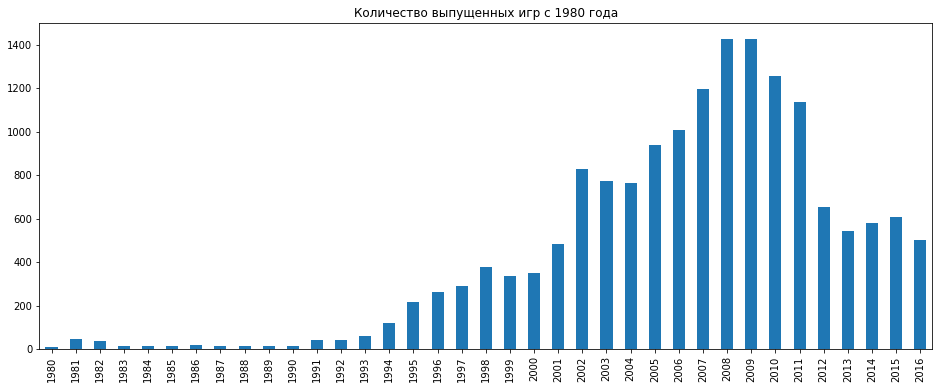

In [15]:
data['year_of_release'].value_counts().sort_index().plot(kind='bar', figsize=(16, 6)).set_title('Количество выпущенных игр с 1980 года')

**До 1995 года выпускалось совсем небольшое количество игр в год, по сравнению со следующим периодом. Игры до 1995 года можно не учитывать в исследовании ввиду малого количества и малого количества продаж.**

## Изменение продаж игр по платформам от года к году

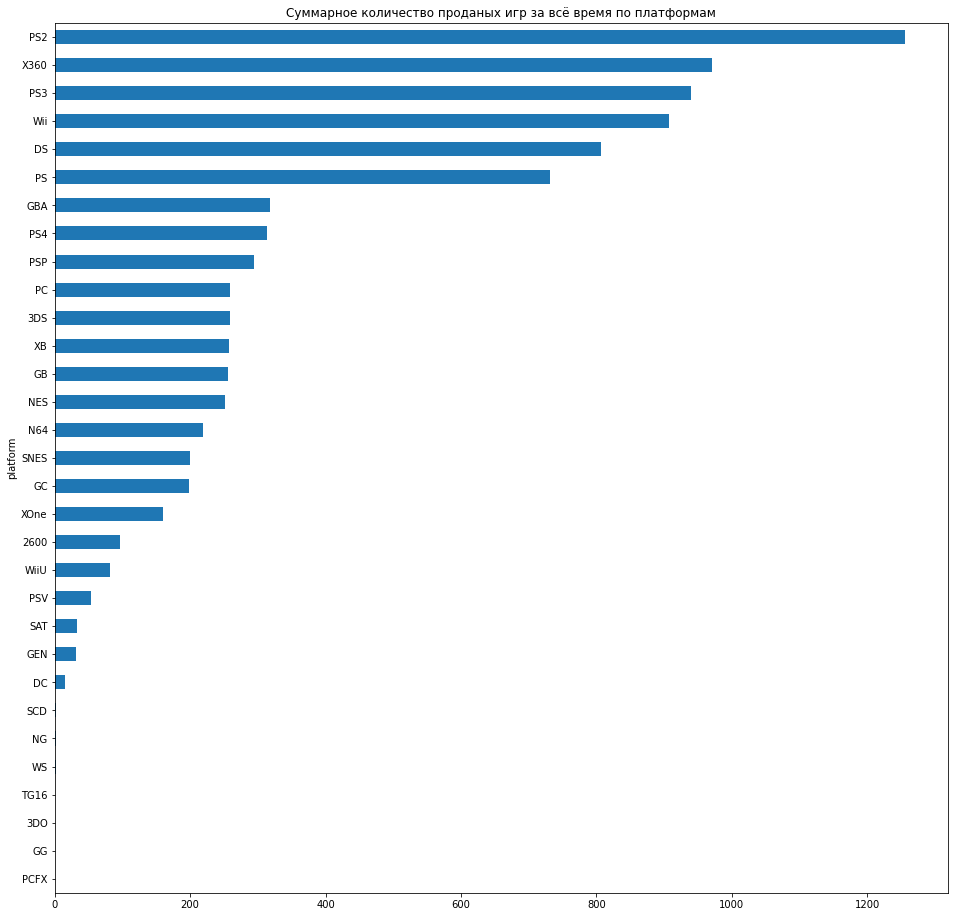

In [16]:
data.groupby('platform')['total_sales'].sum().sort_values(ascending=True).plot(kind='barh', figsize=(16,16)) \
    .set_title('Суммарное количество проданых игр за всё время по платформам');

**Шестерка самых популярных платформ - это PS2, X-box 360, PS3, Wii, DS и PS**

In [17]:
most_popular_list = ['PS', 'PS2', 'X360', 'PS3', 'Wii', 'DS']

In [18]:
data_top_sales = data.query('platform in @most_popular_list')

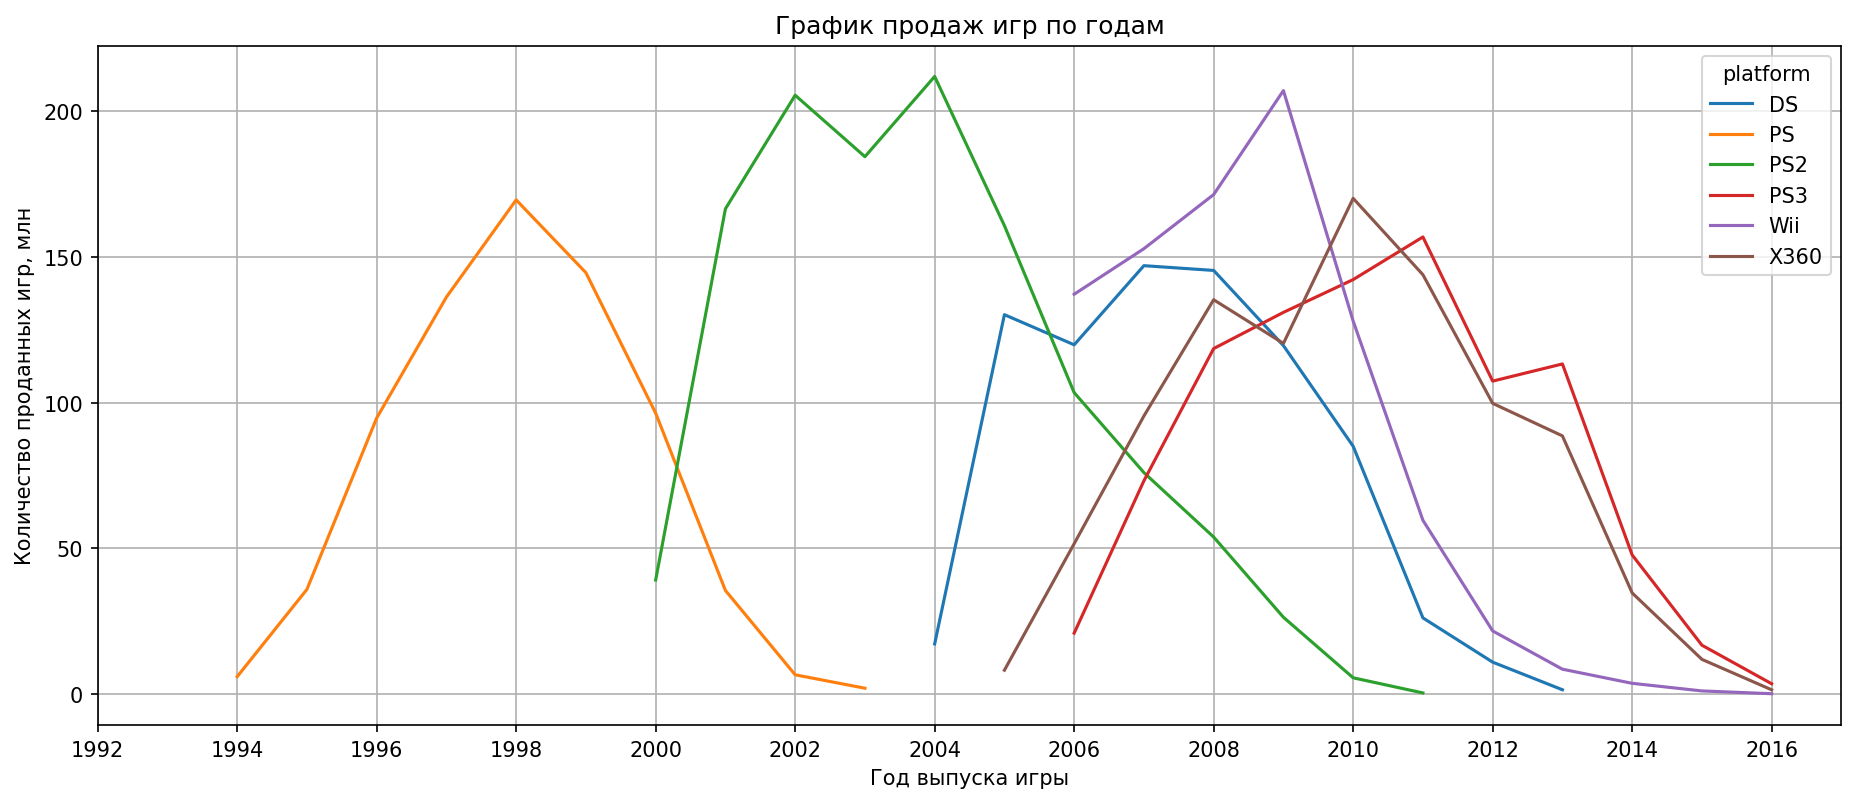

In [19]:
# Код ревьюера

import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(15,6), dpi=150) # dpi отвечает за число пикселей на дюйм

data_top_sales.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum') \
    .plot(grid=True, ax=ax)

ax.set_title('График продаж игр по годам')
ax.set_xlabel('Год выпуска игры');
ax.set_ylabel('Количество проданных игр, млн');
ax.set_xlim((1992,2017))

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

**На графике видно, что жизненный цикл консоли составляет приблизительно 10 лет. Продажи игр активно растут в течение двух-трёх лет с момента выхода платформы, после достигают своего пика, на котором держатся 2 - 3 года, а после постепенно сходят на нет.**

## Самые потенциально интересные консоли на 2017 год

### Оценим суммарные продажи игр по платформам за актуальный период

Исходя их проведенного выше анализа - стоит взять данные за период с 2012 по 2016, так мы сможем увидеть, какие консоли находятся на "пике", какие только начинают свой путь на вершину, а какие уже изживают себя.

In [20]:
data_actual = data.query('year_of_release > 2011')

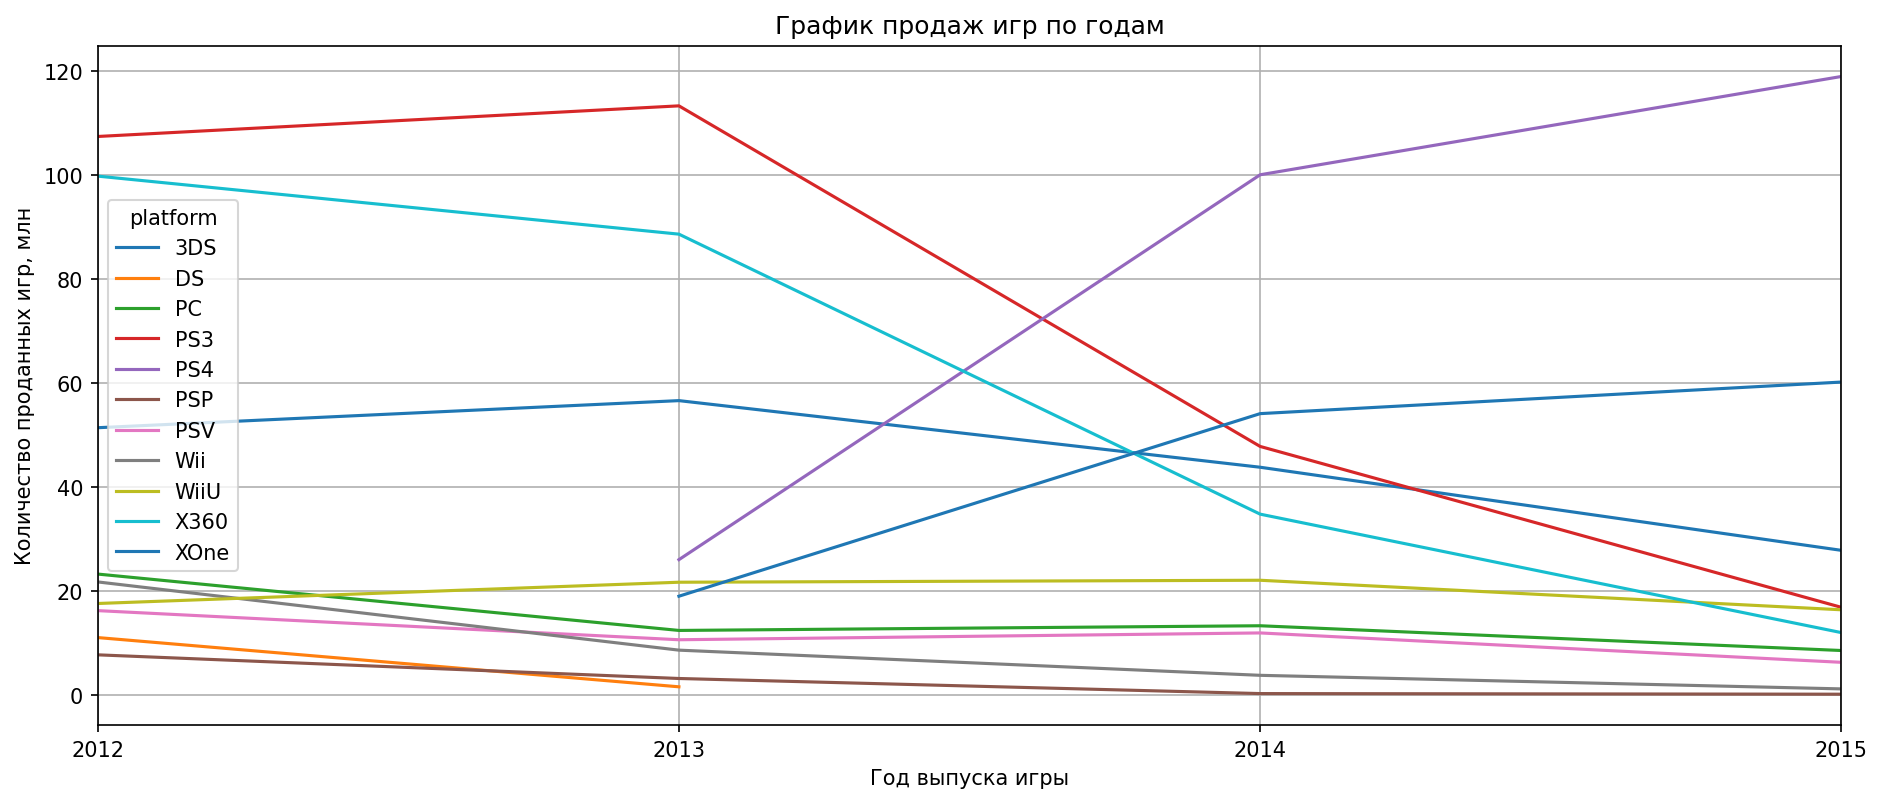

In [21]:
#data_actual.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum') \
#    .plot(grid=True, figsize=(16, 6)).set_title('График продаж игр по годам');
#plt.xlabel('Год выпуска')
#plt.ylabel('Количество проданных игр, млн')
#plt.xlim(2012, 2015)

fig, ax = plt.subplots(figsize=(15,6), dpi=150) # dpi отвечает за число пикселей на дюйм

data_actual.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum') \
    .plot(grid=True, ax=ax)

ax.set_title('График продаж игр по годам')
ax.set_xlabel('Год выпуска игры');
ax.set_ylabel('Количество проданных игр, млн');
ax.set_xlim((2012,2015))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

Можно выделить 3 консоли, продажи игр на которых показывают хорошие результаты: PS4, X-box One и Nintendo 3DS.

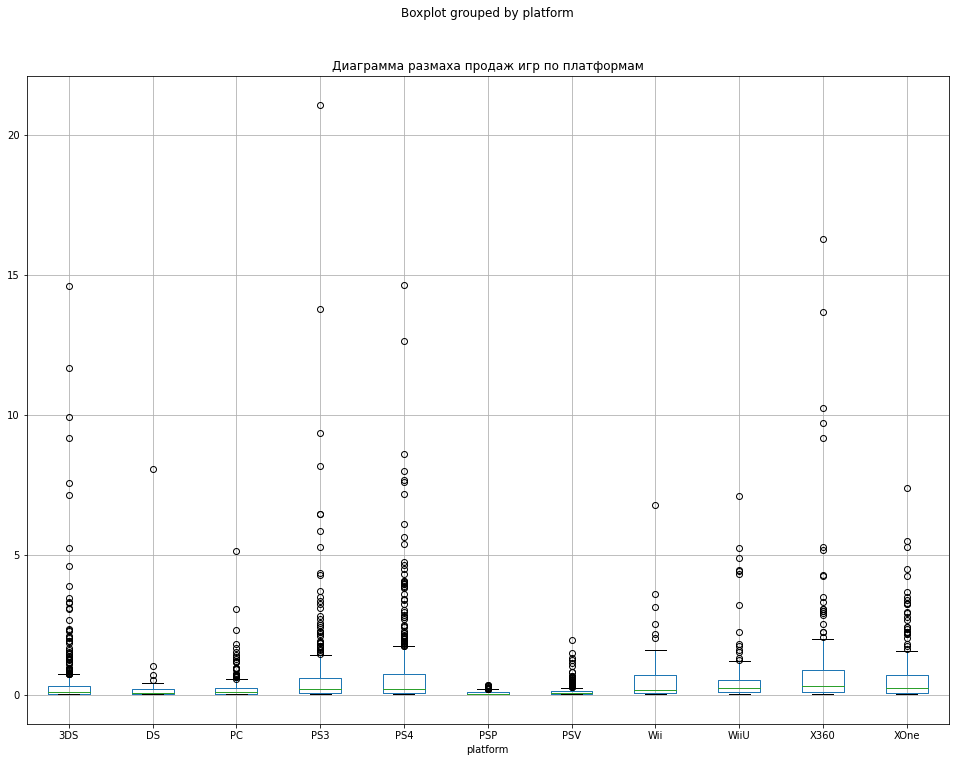

In [22]:
data_actual.boxplot(by='platform', column='total_sales', figsize=(16, 12)) \
    .set_title('Диаграмма размаха продаж игр по платформам');

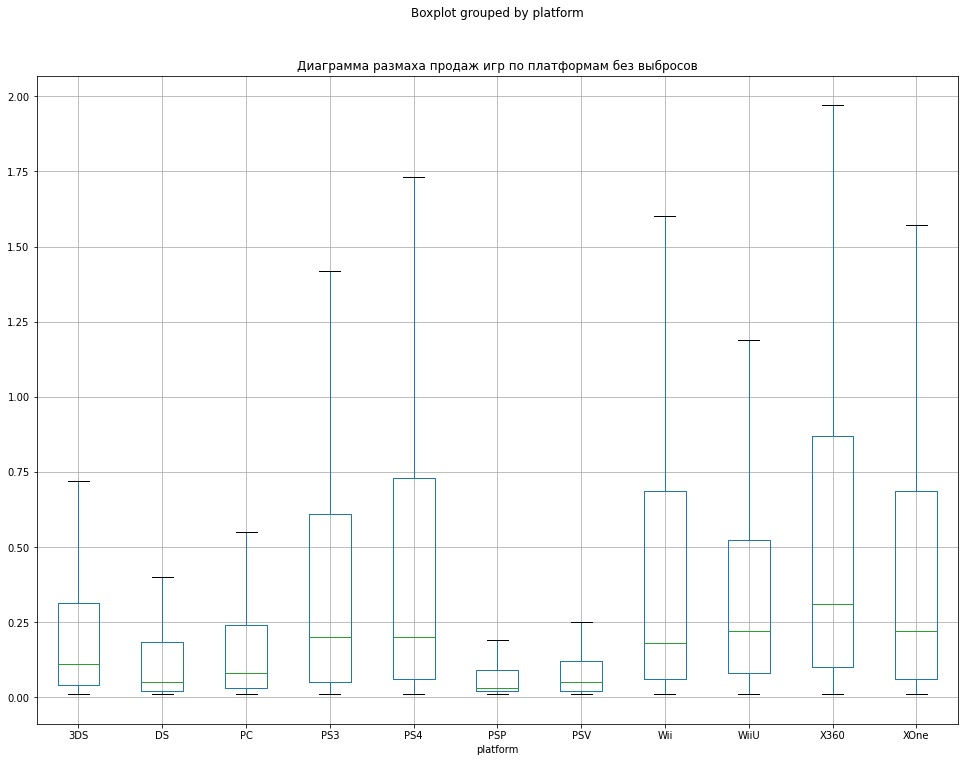

In [23]:
data_actual.boxplot(by='platform', column='total_sales', figsize=(16, 12), showfliers=False) \
    .set_title('Диаграмма размаха продаж игр по платформам без выбросов');

По диаграмме размаха можно сделать следующие выводы:
- В целом, говоря о средних, т.н. "проходных" проектах, общее количество проданных игр на популярных платформах приблизительно одинаковое: первый и третий квартили приблизительно совпадают, медианы находится также на одном уровне.
- На суммарные продажи самое большое влияние оказывают "выбросы", в нашем случае это хитовые игры, количество проданных копий которых и задает общую картину.

### Оценим влияние оценок критиков и пользователей на продажи игр

In [24]:
data_ps4 = data.query('platform == "PS4"')
data_xbox = data.query('platform == "XOne"')
data_3ds = data.query('platform == "3DS"')

Коэффициент корреляции 0.406568


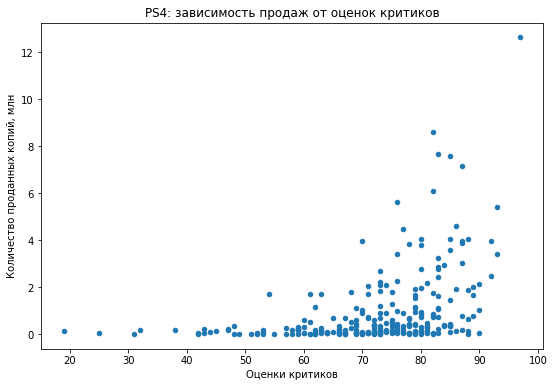

In [27]:
data_ps4.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(9,6)) \
    .set_title('PS4: зависимость продаж от оценок критиков');
print("Коэффициент корреляции {:f}" .format(data_ps4['critic_score'].corr(data_ps4['total_sales'])))
plt.xlabel('Оценки критиков');
plt.ylabel('Количество проданных копий, млн');

Коэффициент корреляции -0.031957


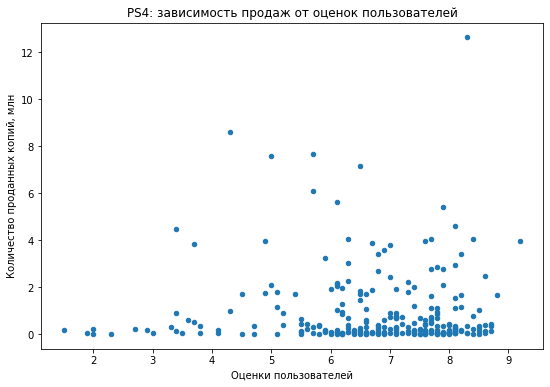

In [28]:
data_ps4.plot(x='user_score', y='total_sales', kind='scatter', figsize=(9,6)) \
    .set_title('PS4: зависимость продаж от оценок пользователей');
print("Коэффициент корреляции {:f}" .format(data_ps4['user_score'].corr(data_ps4['total_sales'])))
plt.xlabel('Оценки пользователей');
plt.ylabel('Количество проданных копий, млн');

Рассмотрим влияние на паре других популярных платформ

Коэффициент корреляции 0.416998


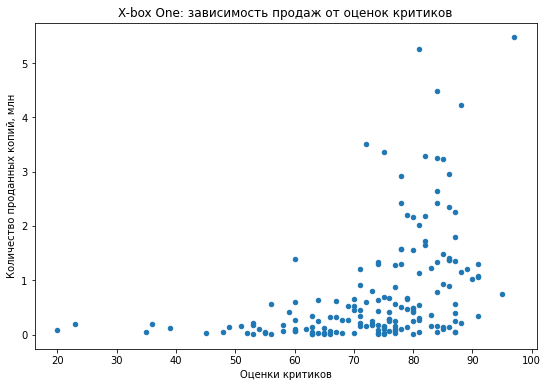

In [29]:
data_xbox.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(9,6)) \
    .set_title('X-box One: зависимость продаж от оценок критиков');
print("Коэффициент корреляции {:f}" .format(data_xbox['critic_score'].corr(data_xbox['total_sales'])))
plt.xlabel('Оценки критиков');
plt.ylabel('Количество проданных копий, млн');

Коэффициент корреляции -0.068925


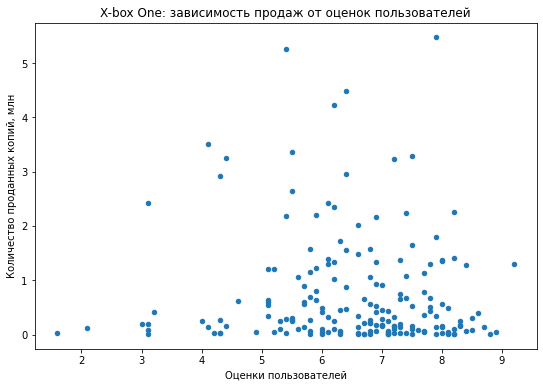

In [30]:
data_xbox.plot(x='user_score', y='total_sales', kind='scatter', figsize=(9,6)) \
    .set_title('X-box One: зависимость продаж от оценок пользователей');
print("Коэффициент корреляции {:f}" .format(data_xbox['user_score'].corr(data_xbox['total_sales'])))
plt.xlabel('Оценки пользователей');
plt.ylabel('Количество проданных копий, млн');

Коэффициент корреляции 0.349401


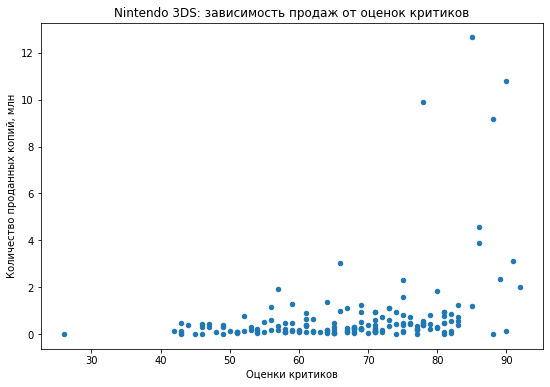

In [31]:
data_3ds.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(9,6)) \
    .set_title('Nintendo 3DS: зависимость продаж от оценок критиков');
print("Коэффициент корреляции {:f}" .format(data_3ds['critic_score'].corr(data_3ds['total_sales'])))
plt.xlabel('Оценки критиков');
plt.ylabel('Количество проданных копий, млн');

Коэффициент корреляции 0.224808


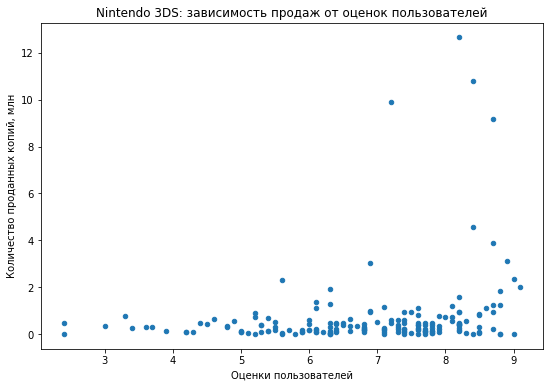

In [32]:
data_3ds.plot(x='user_score', y='total_sales', kind='scatter', figsize=(9,6)) \
    .set_title('Nintendo 3DS: зависимость продаж от оценок пользователей');
print("Коэффициент корреляции {:f}" .format(data_3ds['user_score'].corr(data_3ds['total_sales'])))
plt.xlabel('Оценки пользователей');
plt.ylabel('Количество проданных копий, млн');

**На продажи игр на актуальных консолях ощутимое влияние оказывают оценки критиков, прослеживается взаимосвязь выше оценка - больше проданных копий. Пользовательская оценка игр, как ни странно, не вносит сколько-нибудь заметного влияния на продажи, рейтинг пользователей может быть низким, а по продажам игра в топе. Игры с оценками критиков более 85 в большинстве случаев становятся хитами продаж**

### Оценим влияние жанров игр на продажи

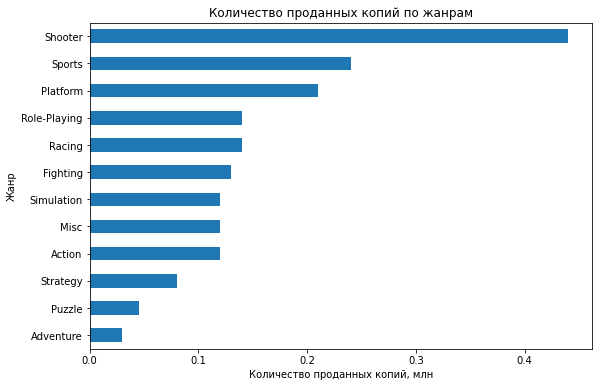

In [37]:
data_actual.groupby('genre')['total_sales'].median().sort_values().plot(kind='barh', figsize=(9,6)) \
    .set_title('Количество проданных копий по жанрам');
plt.xlabel('Количество проданных копий, млн');
plt.ylabel('Жанр');

**Самые продаваемые - игры в жанрах Шутер, также повышенной популярностью пользуются Спортивные игры и Платформеры.**  
**Самый залежавшийся на полках жанр - Приключения, также пониженный спрос наблюдается на Паззлы и Стратегии**

# Портреты пользователей по регионам

## Топ платформ по регионам

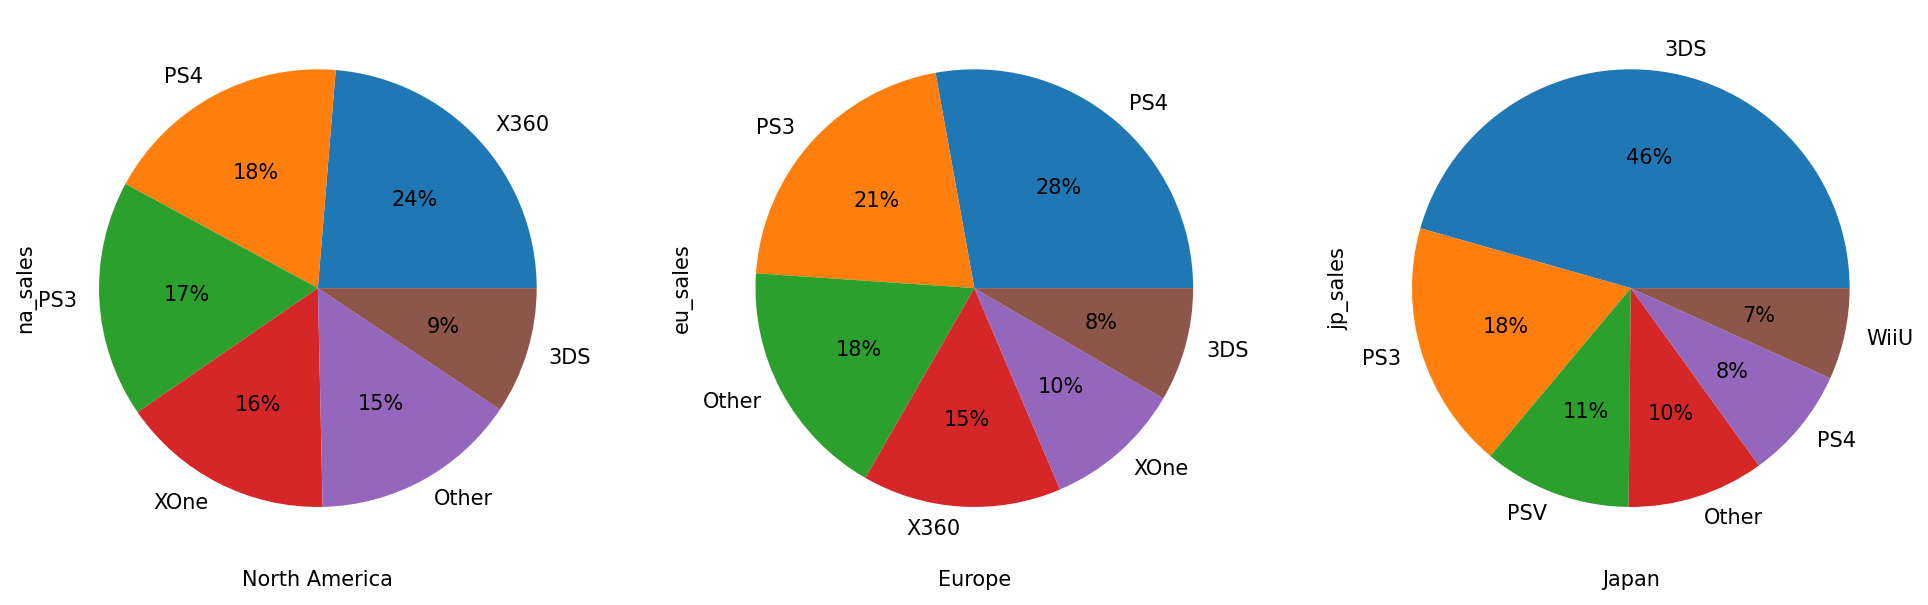

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 12), dpi=150)

data_to_plot1 = data_actual.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum')\
                   .sort_values(by = 'na_sales', ascending = False).reset_index()

data_to_plot1.loc[~data_to_plot['platform'].isin(data_to_plot['platform'].head()), 'platform'] = 'Other'

data_to_plot1.groupby('platform') \
    .agg({'na_sales' : 'sum'}) \
    .sort_values(by = 'na_sales', ascending = False) \
    .plot(kind='pie',
          y='na_sales',
          autopct='%.0f%%',
          ax=ax1,
          legend=False
         )


data_to_plot2 = data_actual.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum')\
                   .sort_values(by = 'eu_sales', ascending = False).reset_index()

data_to_plot2.loc[~data_to_plot['platform'].isin(data_to_plot['platform'].head()), 'platform'] = 'Other'

data_to_plot2.groupby('platform') \
    .agg({'eu_sales' : 'sum'}) \
    .sort_values(by = 'eu_sales', ascending = False) \
    .plot(kind='pie',
          y='eu_sales',
          autopct='%.0f%%',
          ax=ax2,
          legend=False
         )

data_to_plot3 = data_actual.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum')\
                   .sort_values(by = 'jp_sales', ascending = False).reset_index()

data_to_plot3.loc[~data_to_plot['platform'].isin(data_to_plot['platform'].head()), 'platform'] = 'Other'

data_to_plot3.groupby('platform') \
    .agg({'jp_sales' : 'sum'}) \
    .sort_values(by = 'jp_sales', ascending = False) \
    .plot(kind='pie',
          y='jp_sales',
          autopct='%.0f%%',
          ax=ax3,
          legend=False
         )
ax1.set_xlabel('North America')
ax2.set_xlabel('Europe')
ax3.set_xlabel('Japan')
plt.show()

<div class="alert alert-success"; style="border-left: 7px solid green">
<h3>✔ Комментарий ревьюера V.2</h3>
    
👍 Циклом только стоило пройтись по регионами, чтобы код один и тот же не писать</div>    


Топ-5 по региону NA: 
- X-box 360 - 24%
- PS4 - 18%
- PS3 - 17%
- X-box One - 16%
- Nintendo 3DS - 9%

Топ-5 по региону EU:
- PS4 - 28%
- PS3 - 21%
- X-box 360 - 15%
- X-box One - 10%
- Nintendo 3DS - 8%

###### Топ-5 по региону JP:
- Nintendo 3DS - 46%
- PS3 - 18%
- PSV - 11%
- PS4 - 8%
- WiiU - 7%

**В США и Европе наибольшей популярностью пользуются игры для консолей PS и X-box, они уверенно держат 4 верхние строчки в рейтинге, пятое же место в обоих случаях занимает Nintendo 3DS, не превышая 10% от от общего объема продаж.**
**В Японии ситуация иная: игры для Nintendo 3DS занимают почти половину рынка, а ближайший к ним конкурент, консоль PS3, довольствуется лишь 18% от продаж**

In [77]:
# Код ревьюера
#
#fig, ax = plt.subplots(figsize=(3,3), dpi=150)
#
#data_to_plot = data_actual.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum')\
#                   .sort_values(by = 'na_sales', ascending = False).reset_index()
#
#data_to_plot.loc[~data_to_plot['platform'].isin(data_to_plot['platform'].head()), 'platform'] = 'Other'
#
#data_to_plot.groupby('platform') \
#    .agg({'na_sales' : 'sum'}) \
#    .sort_values(by = 'na_sales', ascending = False) \
#    .plot(kind='pie',
#          y='na_sales',
#          autopct='%.0f%%',
#          ax=ax,
#          legend=False
#         )
#ax.set_ylabel('')
#plt.show()

## Топ жанров по регионам

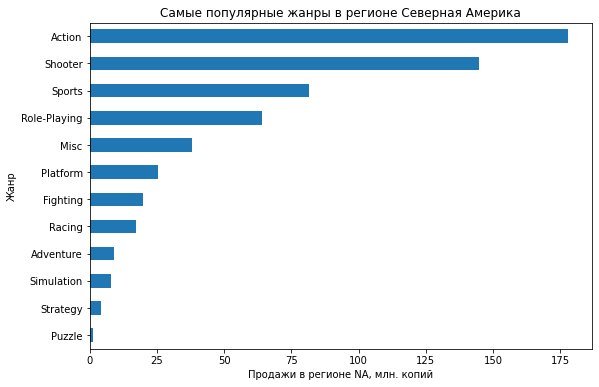

In [42]:
data_actual.groupby('genre')['na_sales'].sum().sort_values(ascending=True).plot(kind='barh', figsize=(9, 6)) \
    .set_title('Самые популярные жанры в регионе Северная Америка');
plt.xlabel('Продажи в регионе NA, млн. копий');
plt.ylabel('Жанр');

Топ-5 жанров в NA:
- Action
- Shooter
- Sports
- RPG
- Misc

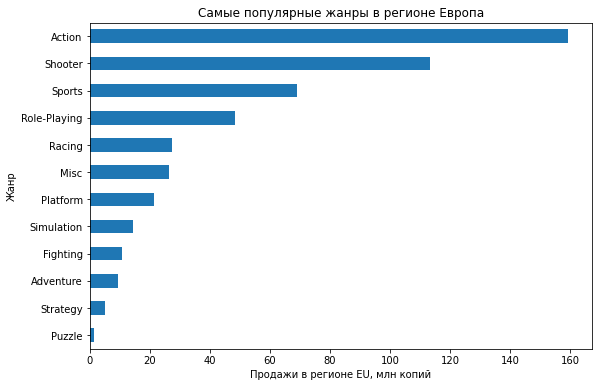

In [43]:
data_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending=True).plot(kind='barh', figsize=(9, 6)) \
    .set_title('Самые популярные жанры в регионе Европа');
plt.xlabel('Продажи в регионе EU, млн копий');
plt.ylabel('Жанр');

Топ-5 жанров в EU:
- Action
- Shooter
- Sports
- RPG
- Racing

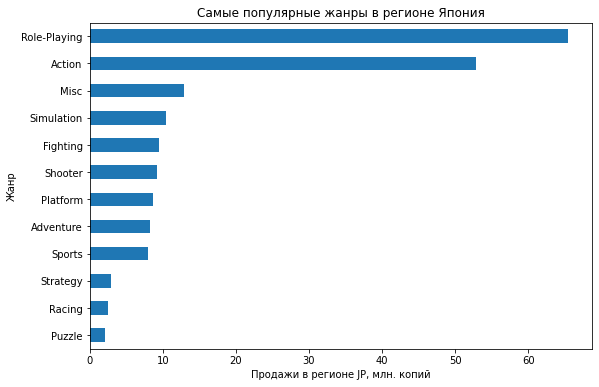

In [44]:
data_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending=True).plot(kind='barh', figsize=(9, 6)) \
    .set_title('Самые популярные жанры в регионе Япония');
plt.xlabel('Продажи в регионе JP, млн. копий');
plt.ylabel('Жанр');

Топ-5 жанров в регионе Япония:
- RPG
- Action
- Misc
- Simulation
- Fighting

**Вкусы пользователей в Америке и Европе очень схожи, первые четыре строчки идентичны, отличается лишь пятое место в рейтинге. Япония же отличается любителями симуляторов и файтингов**

## Влияние рейтинга ESRB на продажи в регионе

In [52]:
data_actual['rating'] = data_actual['rating'].fillna('No rating');
data_actual.loc[data_actual['rating']=='No rating']['name'].unique()

/tmp/ipykernel_31/4082870032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_actual['rating'] = data_actual['rating'].fillna('No rating');


array(['Call of Duty: Black Ops 3', 'Pokemon X/Pokemon Y',
       'Pokemon Omega Ruby/Pokemon Alpha Sapphire', 'Minecraft',
       'Pokemon Black 2/Pokemon White 2', 'Star Wars Battlefront (2015)',
       'Super Smash Bros. for Wii U and 3DS', 'Pokemon Sun/Moon',
       'Tomodachi Life', 'The Last of Us', 'Monster Hunter 4',
       'Monster Hunter X', 'Yokai Watch 2 Ganso/Honke',
       'Need for Speed: Most Wanted', 'Yokai Watch 2 Shinuchi',
       'Need for Speed (2015)', 'Tomb Raider (2013)',
       'Yokai Watch Busters', 'Yokai Watch', 'Mario & Luigi: Dream Team',
       'Donkey Kong Country Returns',
       'The Legend of Zelda: The Wind Waker', 'The Elder Scrolls Online',
       'Kingdom Hearts', ' Fire Emblem Fates', 'Ratchet & Clank (2016)',
       'Puzzle & Dragons', 'Doom (2016)', 'LEGO City Undercover',
       'Dragon Quest VII: Warriors of Eden',
       'Bravely Default: Flying Fairy', 'Yokai Watch 3',
       'The Elder Scrolls V: Skyrim', 'Kingdom Hearts II',
       'Farmi

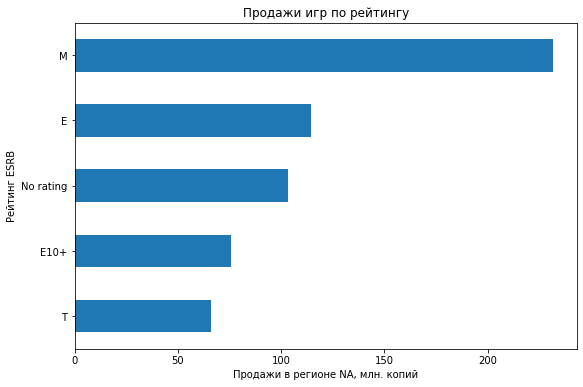

In [53]:
data_actual.groupby('rating')['na_sales'].sum().sort_values(ascending=True).plot(kind='barh', figsize=(9, 6)) \
    .set_title('Продажи игр по рейтингу');
plt.xlabel('Продажи в регионе NA, млн. копий');
plt.ylabel('Рейтинг ESRB');

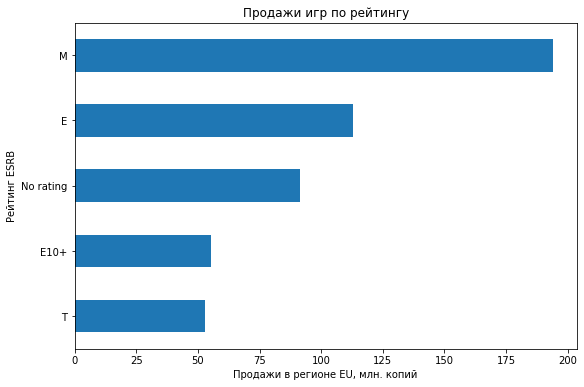

In [54]:
data_actual.groupby('rating')['eu_sales'].sum().sort_values(ascending=True).plot(kind='barh', figsize=(9, 6)) \
    .set_title('Продажи игр по рейтингу');
plt.xlabel('Продажи в регионе EU, млн. копий');
plt.ylabel('Рейтинг ESRB');

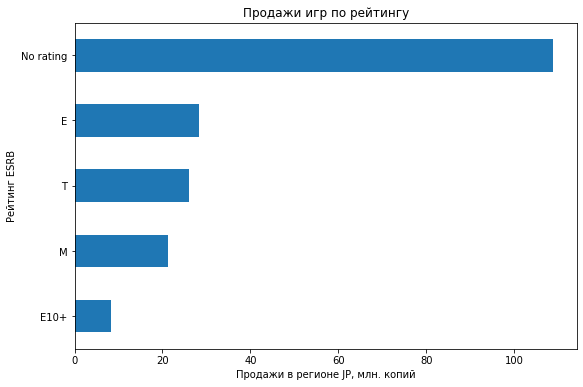

In [55]:
data_actual.groupby('rating')['jp_sales'].sum().sort_values(ascending=True).plot(kind='barh', figsize=(9, 6)) \
    .set_title('Продажи игр по рейтингу');
plt.xlabel('Продажи в регионе JP, млн. копий');
plt.ylabel('Рейтинг ESRB');

**В США и Европе рейтинги очень похожи: наибольшей популярностью пользуются игры с рейтингом "Для взрослых". За ними идут игры "Для всех", затем "От 10 лет" и "Для подростков". Однако, весомую долю вносят игры с пропущенным значением рейтинга. Если предположить, что пропуск в рейтинге означает "Для всех", то игры с данным рейтингом выравниваются по популярности с играми "Для взрослых".**  
**В Японии снова картина иная: судя по всему, т.к. система ESRB, в основном применяется в западном мире, японские компании не обременяют себя присваиванием рейтингов игр, и, как следствие, игры без рейтинга составляют более половины от всех, опережая с четырёхкратным отрывом все остальные игры. После игр без рейтинга самые популярные - "Для всех", за ними идут "Для подростков", "Для взрослых" и "От 10 лет". Также можно отметить, что разброс между продажами игр по рейтингу ESRB в Японии невелик по сравнению с США и Европой, где игры "Для взрослых" сильно опережают остальные.**

# Проверка гипотез

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Для проверки гипотез используем метод проверки гипотезы о равенстве средних двух независимых генеральных совокупностей.

In [57]:
rating_xbox = data_actual.query('platform == "XOne"')['user_score']#.dropna()
rating_pc = data_actual.query('platform == "PC"')['user_score']#.dropna()

In [67]:
# Н0: средние пользовательские рейтинги платформ Xbox One и PC одинаковы.
# Н1: средние пользовательские рейтинги платформ Xbox One и PC разные.

alpha = .05
results = st.ttest_ind(
    rating_xbox, 
    rating_pc,
    nan_policy='omit')

print('p-значение: {}' .format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Для самопроверки, расчитаем средние

In [68]:
rating_xbox.mean()

6.521428571428572

In [69]:
rating_pc.mean()

6.4286407766990274

**Средние пользовательские рейтинги на платформах Xbox One и РС одинаковые.**

In [70]:
rating_sport = data_actual.query('genre == "Sports"')['user_score']#.dropna()
rating_action = data_actual.query('genre == "Action"')['user_score']#.dropna()

In [71]:
# H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые.
# H1: Средние пользовательские рейтинги жанров Action и Sports разные.

alpha = .05
results = st.ttest_ind(
    rating_sport, 
    rating_action,
    nan_policy='omit')

print('p-значение: {}' .format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


In [72]:
rating_sport.mean()

5.455897435897437

In [73]:
rating_action.mean()

6.825047801147227

**Средние пользовательские рейтинги жанров Action и Sports разные.**

# Общий вывод

На входе были получены данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Цель исследования - определить закономерности, определяющие успешность продаж игр.  

Факторы для анализа, оценки и выводов:  

   * платформа выпуска игры
   * отзывы критиков
   * отзывы пользователей
   * жанр игры
   * регион продажи
   * возрастной рейтинг

Результаты проведенного исследования:

1. Самые потенциально успешные платформы на 2017 год это: PlayStation 4, Xbox One и Nintendo 3DS. PS4 & Xbox One только набирают обороты, и, судя по данным, выйдут на пик своих продаж как раз в 2017 году. Продажи Nintendo 3DS заметно хуже, однако платформа очень популярна в регионе JP.
2. Успешность продаж обеспечивают отзывы критиков, игры с высокоми оценками с большой долей вероятности становятся хитами продаж. Очень хороший знак для потенциального хита - рейтинг критиков более 85, такие игры, в массе своей, показывают высокие продажи.
3. Отзывы игроков, как ни странно, не вносят никакого эффекта и не влияют на продажи игр. Есть как хитовые игры с низкими оценками, так и пропущенные аудиторией с высокими.
4. В целом по миру, самые прибыльные - игры в жанрах Экшн, Стрелялки, РПГ и спортивные. Наименьшим успехом пользуются Паззлы, Стратегии, Приключения и Симуляторы. Однако, существует зависимость в т.ч. и от региона продаж, в Японии Топ-5 выглядит следующим образом: RPG, Action, Misc, Simulator, Fighting.
5.В США и Европе рейтинги очень похожи: наибольшей популярностью пользуются игры с рейтингом "Для взрослых". За ними идут игры "Для всех", затем "От 10 лет" и "Для подростков". Однако, весомую долю вносят игры с пропущенным значением рейтинга. Если предположить, что пропуск в рейтинге означает "Для всех", то игры с данным рейтингом выравниваются по популярности с играми "Для взрослых".**  
В Японии снова картина иная: судя по всему, т.к. система ESRB, в основном применяется в западном мире, японские компании не обременяют себя присваиванием рейтингов игр, и, как следствие, игры без рейтинга составляют более половины от всех, опережая с четырёхкратным отрывом все остальные игры. После игр без рейтинга самые популярные - "Для всех", за ними идут "Для подростков", "Для взрослых" и "От 10 лет". Также можно отметить, что разброс между продажами игр по рейтингу ESRB в Японии невелик по сравнению с США и Европой, где игры "Для взрослых" сильно опережают остальные.

Также в результате исследования было исследованы две гипотезы и сделаны следующие выводы:  

* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action и Sports разные.  

**В общем, итогом исследования стал очевидный факт, что недавно выпущенные платформы PS4 и Xbox One - тот вариант на который стоит сделать ставку, особенно для продаж в США и Европе, а для региона JP прекрасным дополнением станет консоль Nintendo 3DS, забирающая почти половину продаж всех игр в регионе. Рекомендуется обратить внимание на отзывы критиков и ожидать лучших продаж от игр с лучшими оценками и не делать поспешных выводов по отзывам пользователей.**